# **Предсказание дефолта по кредиту**

---



In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import plotly.express as px
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, validation_curve
from sklearn.metrics import roc_auc_score, f1_score, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, classification_report, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from matplotlib import pyplot
import warnings

In [ ]:
df = pd.read_csv('credit_risk_dataset.csv', sep=',')

In [ ]:
df.shape

(32581, 12)

Всего в таблице представлено 32581 объект и 12 признаков

In [ ]:
df.head(8)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
6,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
7,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,N,4


In [ ]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

- `loan_status` - целевая переменная (1-дефолт, 0-нет дефолта);

- `person_age` — возраст;

- `person_income` — годовой доход (в долларах);

- `person_home_ownership` — домовладение ('rent'-аренда, 'mortgage'-ипотека, 'own'-собственник);

- `person_emp_length` — стаж работы (в годах);

- `loan_intent` — цель кредита ('education'-образование, 'medical'-лечение, 'venture'-предприятие, 'home improvement'-обустройство дома, 'presonal'-личный, 'debt consolidation'-погашение старого долга);

- `loan_grade` — рейтинг кредита (“A”, “B”, “C”, “D”, “E”, “F” , “G”);

- `loan_amnt` — сумма кредита (в долларах);

- `loan_int_rate`— процентная ставка;

- `loan_percent_income` — процентный доход от займа;

- `cb_person_default_on_file` — был ли в прошлом дефолт ('Y'-да, 'N'-нет);

- `cb_person_cred_hist_length` — кредитная история.



**Предобработка данных**
---



Поиск пропущенный значений среди признаков в % (округление до 1 знака после ,)

In [ ]:
round(df.isnull().sum()/df.shape[0] * 100,1)

person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             2.7
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 9.6
loan_status                   0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
dtype: float64

Есть пропущенные значения в признаках "Стаж" и "Процентная ставка". Но отсутствующие значения представляют небольшой процент от набора данных. Удалим строки, содержащие отсутствующие значения

In [ ]:
df = df.dropna(axis=0)

In [ ]:
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

Просмотр описательной статистики важен для общего представления данных:

In [ ]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,28638.000000,2.863800e+04,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000
mean,27.727216,6.664937e+04,4.788672,9656.493121,11.039867,0.216600,0.169488,5.793736
std,6.310441,6.235645e+04,4.154627,6329.683361,3.229372,0.411935,0.106393,4.038483
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.948000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.595600e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


Максимальное значение признака "Возраст" - 144 года, у признака "Стаж" максимальное значение - 123 года. В данных есть выбросы, что может ухудшить модель. Далее для рассмотрения возможных выбросов будет использована матрица диаграммы рассеяния

In [ ]:
fig = px.scatter_matrix(df, dimensions=
['person_age', 'person_income', 'person_emp_length', 'loan_amnt','loan_int_rate'],
labels={col:col.replace('_', ' ') for col in df.columns},
height=900, color_continuous_scale=px.colors.diverging.Tealrose)
fig.show();

Кроме выбросов в данных столбцов "Возраст", "Стаж", можно заметить выброс и в столбце "Доход". Благодаря визуализации можно установить пороговые значения, тем самым устранив аномалии


In [ ]:
df = df[(df["person_age"]<=100) & (df["person_income"]<= 4000000) & (df["person_emp_length"]<=100)]
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,28632.000000,2.863200e+04,28632.000000,28632.000000,28632.000000,28632.000000,28632.000000,28632.000000
mean,27.712140,6.642651e+04,4.780316,9655.331447,11.039701,0.216611,0.169489,5.793553
std,6.171989,5.154746e+04,4.035616,6327.798706,3.229409,0.411942,0.106361,4.037133
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.945600e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.590000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,84.000000,2.039784e+06,41.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


Диаграмма рассеяния после удаления выбросов:

In [ ]:
fig = px.scatter_matrix(df, dimensions=
['person_age', 'person_income', 'person_emp_length', 'loan_amnt','loan_int_rate'],
labels={col:col.replace('_', ' ') for col in df.columns},
height=900, color_continuous_scale=px.colors.diverging.Tealrose)
fig.show();

Рассмотрим отношение классов (1-есть дефолт, 0-нет дефолта) в целевой переменной

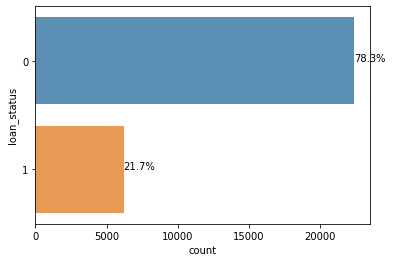

In [ ]:
ax=sns.countplot(y = "loan_status", data=df, alpha=0.8);
total=df.shape[0]

for i in ax.patches:
  per='{:.1f}%'.format(100*i.get_width()/total)
  x=i.get_x() + i.get_width()
  y=i.get_y() + i.get_height()  /2
  ax.annotate(per, (x,y))
plt.show()

Есть дисбаланс классов (люди чаще не допускают дефолт), это нужно учесть при построении модели

Построим тепловую карту для поиска мультиколлинеарности признаков

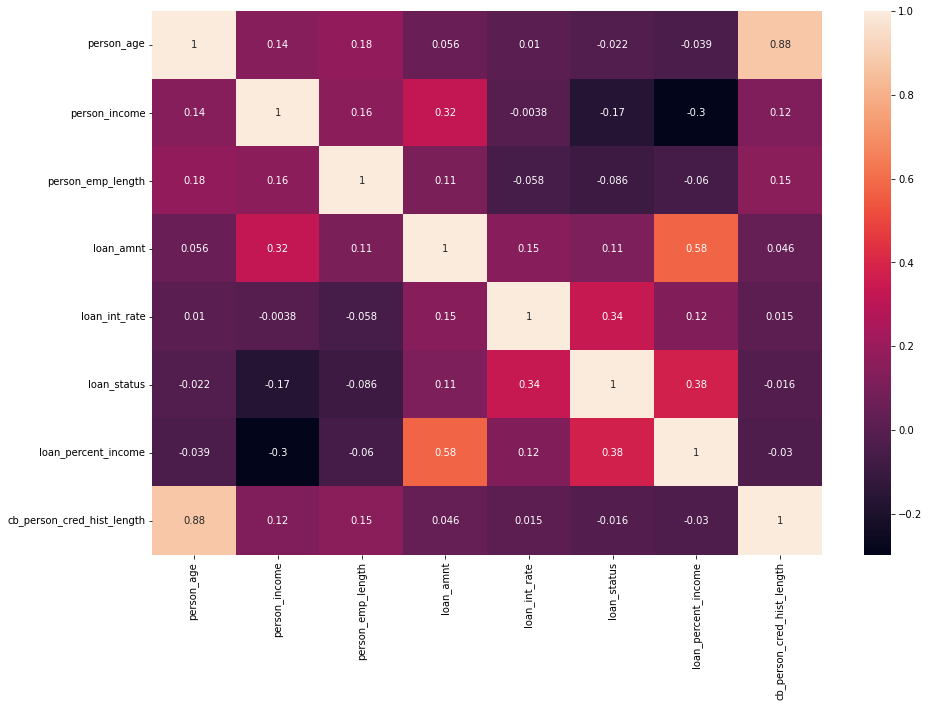

In [ ]:
def corrplot(data,labels=[]):
    f,ax = plt.subplots(figsize=(15,10))
    sns.heatmap(data=data.drop(labels=labels, axis=1).corr(), annot=True)
    plt.show()
corrplot(data=df)

Признаки  возраст и длина кредитной истории сильно коррелируют между собой ('person_age' и 'cb_person_cred_hist_length'). Следует удалить столбец с данными о длине кредитной истории. Также можно посмотреть как признаки коррелируют с целевой переменной ('loan_status'). Признак возраст очень слабо коррелирует с целевой переменной, это может быть связано с тем, что большинство людей из таблицы имеют примерно одинаковый возраст. Необходимо построить гистограммы распределния признаков и посмотреть, как распределены данные

In [ ]:
del df['cb_person_cred_hist_length']

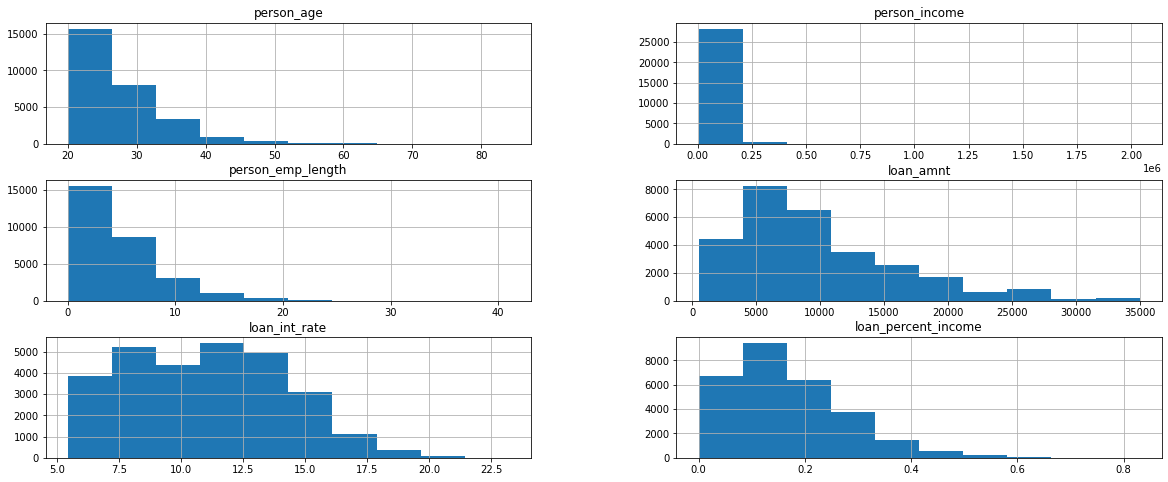

In [ ]:
columns=['person_age', 'person_income','person_emp_length', 'loan_amnt','loan_int_rate', 'loan_percent_income']
df[columns].hist(figsize=(20,8));


In [ ]:
(((df['person_age'] > 20) & (df['person_age'] < 30)).sum()) / df.shape[0]  * 100     #  доля заёмщиков от 20 до 30 лет от общего числа заёмщиков

72.19195305951384

In [ ]:
(df['person_emp_length'] <= 10).sum() / df.shape[0]  * 100      #  доля заёмщиков со стажем, не превышающем 10 лет

90.7865325509919

In [ ]:
(df['person_income'] <= 250000).sum() / df.shape[0]  * 100        #  доля заёмщиков с годовым доходом не более 250 000 долларов

99.26655490360436

In [ ]:
(df['loan_percent_income'] < 0.3).sum() / df.shape[0]  * 100         #  доля заёмщиков, которые отдают менее 30% от дохода на уплату кредита

87.03548477228276

Большую часть заёмщиков (72,2%)представляют люди от 20 до 30 лет, стаж работы в основном не превышает 10 лет (91%), у абсолютного большинства людей годовой доход до 250 000 долларов (99,3%), а процент доходов, который идёт на погашение кредита, чаще менее 30% (в 87% случаев).

# **Гипотезы**

---




*   Люди, совершавшие дефолт, имели более высокую ставку процента
*   Собственники жилья реже совершали дефолт, чем люди арендующие жильё

*   Средний доход людей с дефолтом ниже, чем средний доход людей погасивших кредит
*   Дефолту больше подвержены люди, у которых в прошлом уже был дефолт
*   Наиболее "популярный" кредит среди молодых людей - кредит на образование






Пострение столбчатых диаграмм позволяет увидеть связь признаков типа "объект" и целевой переменной. Все признаки следует отнормировать по целевой переменной, чтобы не получить количественные характеристики

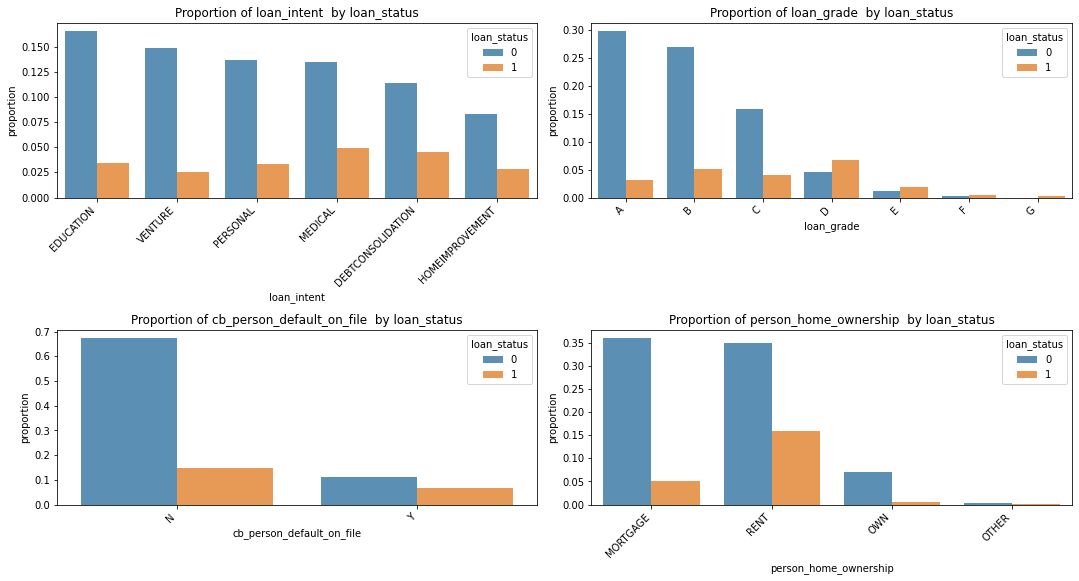

In [ ]:

cols_obj = df[['loan_intent','loan_grade','cb_person_default_on_file','person_home_ownership']]
#строим графики признаков типа объект от значения таргета, отнормируем на размер датасета
plt.figure(figsize=[15, 20])

i = 1
y, hue = "proportion", "loan_status"

for f in cols_obj:
    plt.subplot(5, 2, i)
    df[[f, 'loan_status']]\
        .value_counts(normalize=True)\
        .rename(y)\
        .reset_index()\
        .pipe((sns.barplot, "data"), x=f, y='proportion', hue='loan_status', alpha=0.8)
    plt.title("Proportion of {}  by loan_status".format(f))
    plt.xticks(rotation=45, ha='right')
    i += 1
plt.tight_layout()
plt.show()

Заемщики меньше всего брали кредит на обустройство жилья и больше всего - на образование. Поскольку рейтинг кредита (A-G) представлен в порядке ухудшения оценки этого кредита, то чем ниже рейтинг кредита, тем больше доля людей с дефолтом. При этом, **ни один заемщик** **с кредитным рейтингом G не смог погасить свой кредит**

**Гипотеза 1** : Люди, совершавшие дефолт, имели более высокую ставку процента

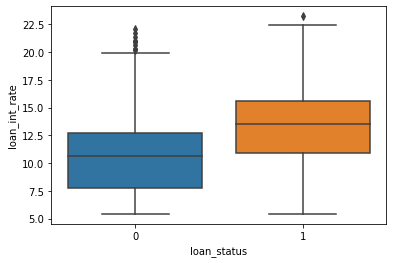

In [ ]:
sns.boxplot(x='loan_status', y='loan_int_rate',data=df);

Действительно, ставка процента по кредиту у людей, непогасивших кредит, выше. Это может свидетельствовать о том, как ставка процента влияет на способность человека выплачивать кредит. Можно предположить, чем выше ставка процента, тем выше риск невыплаты долга.

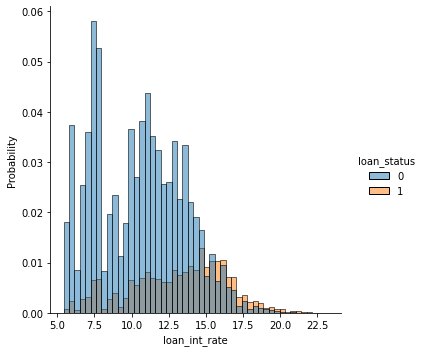

In [ ]:
sns.displot(x='loan_int_rate',
            hue='loan_status',
            data=df,
            stat="probability")
plt.show()

Если ставка процента превышает 15%, то количество дефолтов начинает превышать количество не-дефолтов. Из графика видно, чем больше ставка процента, тем чаще люди не погашали кредит

**Гипотеза 2** : Собственники жилья реже совершали дефолт, чем люди арендующие жильё

In [ ]:
rent = df[df['person_home_ownership']=='RENT'].loan_status.values
own = df[df['person_home_ownership']=='OWN'].loan_status.values

$$
\begin{aligned}
&H_0: \hspace{2mm} p_1 = p_2 \hspace{2mm} \text{Доля дефолтов одинакова} \\
&H_1: \hspace{2mm} p_1 > p_2  \hspace{2mm} \text{Арендующие жилье чаще совершали дефолт} \end{aligned}
$$

In [ ]:
alpha=0.05
n1,n2 = rent.size, own.size
m1,m2 = rent.sum(), own.sum()
p1,p2 = rent.mean(), own.mean()
diff=p1-p2
P=(m1+m2)/(n1+n2)
diff_std = np.sqrt(P*(1-P)*(1/n1 + 1/n2))
z_obs = diff/diff_std
z_crit = stats.norm.ppf(1-alpha)

#z_obs, p_val = proportions_ztest(m_obs, n_obs, value=0, alternative='larger')

In [ ]:
z_obs, z_crit

(23.88331868608021, 1.6448536269514722)

Наблюдаемое значение (23,88) > критического значения (1,64), H0 отвергается, люди арендующие жильё чаще совершают дефолт

Построим график распределения статистики для визуализации результатов проверки гипотезы

In [ ]:
def asy_mean_test(mean_hat, std_hat, mu_0=0,
                   alpha=0.05, alternative='two-sided', margin=3):

    z_obs = (mean_hat - mu_0)/std_hat

    if alternative == 'two-sided':
        p_value = 2 * (1 - stats.norm().cdf(np.abs(z_obs)))
        z_crit = stats.norm().ppf(1 - alpha/2)

        statistics = ['-z_crit', 'z_crit', '-z_obs', 'z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'),
                                       (z_crit, 0.05, z_crit, margin, 'b'),
                                       (-z_obs, -0.6, -margin, -z_obs, 'r'),
                                       (z_obs, 0.1, z_obs, margin, 'r')]))

    if alternative == 'less':
        p_value = stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)

        statistics = ['-z_crit', '-z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'),
                                       (-z_obs, -0.6, -margin, -z_obs, 'r')]))

    if alternative == 'larger':
        p_value = 1 - stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)

        statistics = ['z_crit', 'z_obs']
        params = dict(zip(statistics, [(z_crit, 0.05, z_crit, margin, 'b'),
                                       (z_obs, 0.1, z_obs, margin, 'r')]))


    plt.figure(figsize = (10, 5))
    x = np.linspace(-margin, margin)
    pdf = stats.norm().pdf(x)

    plt.plot(x, pdf, color="black")
    plt.ylabel("$f(x)$", fontsize=16)
    plt.xlabel("$x$", fontsize=16)
    y_max = plt.ylim()[1]

    for i in range(len(statistics)):
        statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]

        plt.axvline(statistic, color=color, linestyle="--", lw=2)
        h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
        plt.text(statistic + text_margin,
                 h*y_max, round(statistic, 2), color=color, fontsize=16)

        xq = np.linspace(left_bound, right_bound)
        yq = stats.norm().pdf(xq)
        plt.fill_between(xq, 0, yq, color=color, alpha=0.2)

    return p_value

0.0

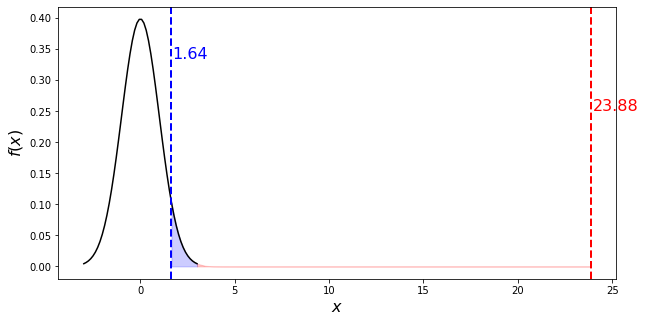

In [ ]:
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05, alternative='larger')

Правосторонняя альтернативная гипотеза, всё что левее критического значения - область принятия H0. Наблюдаемое значение лежит правее критического значения, т.е находится в области, где H0 отвергается. Можно сделать вывод: люди, арендующие жильё чаще совершают дефолт, чем люди с собственным жильём. Это можно объяснить тем, что аренда жилплощади - дополнительное долговое обязательство, люди вынуждены платить и за жилье, и по кредиту. Поэтому риск невыплаты кредита выше.

**Гипотеза 3** : Средний доход людей с дефолтом ниже, чем средний доход людей погасивших кредит

In [ ]:
pd.DataFrame(df.groupby('loan_status')['person_income'].mean())


,person_income
loan_status,
0,70953.827463
1,50053.105127


Средний доход людей с дефолтом заметно ниже, чем средний доход людей погасивших кредит. Гипотеза не отвергается

**Гипотеза 4** : Дефолту больше подвержены люди, у которых в прошлом уже был дефолт

Построение столбчатой диаграммы позволит увидеть соотношение "дефолт в прошлом - дефолт в настоящем"

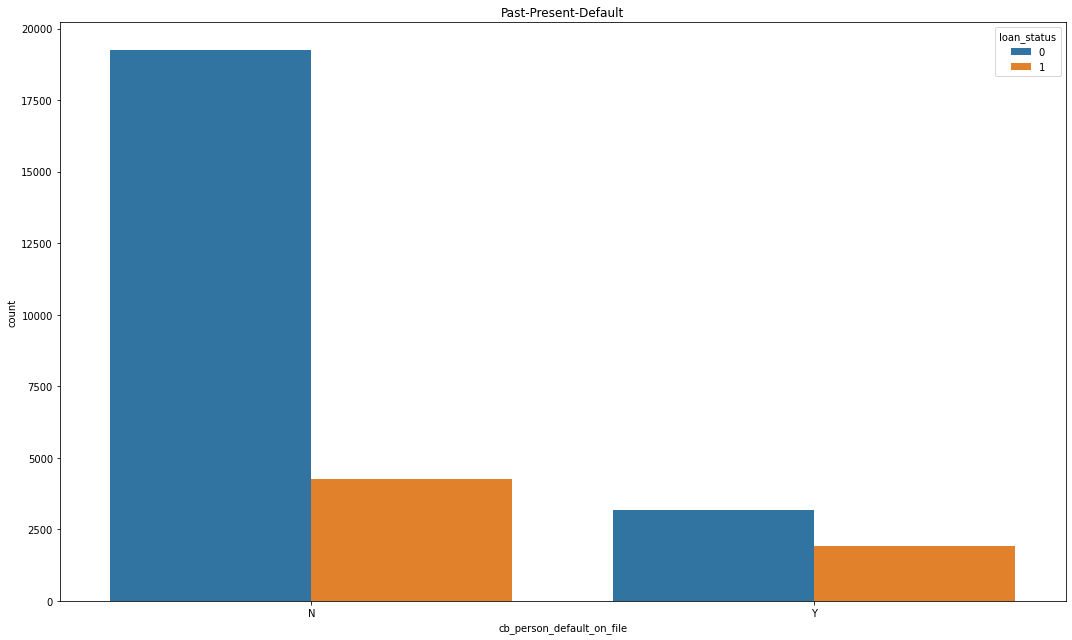

In [ ]:
cols_obj = df['cb_person_default_on_file']
#строим графики признаков типа объект от значения таргета, отнормируем на размер датасета
plt.figure(figsize=[15, 9])


sns.countplot(data= df, x = cols_obj, hue='loan_status')
plt.title('Past-Present-Default')
plt.tight_layout()

Рассчитаем долю людей с дефолтом, при условии, что в прошлом у них тоже был дефолт

In [ ]:
round(((df['cb_person_default_on_file']=='Y') & (df['loan_status']==1)).sum()/(df['cb_person_default_on_file']=='Y').sum() * 100 ,1)

37.7

**37,7%** людей, в прошлом имевшие дефолт, в настоящем также не погашают кредиты

Доля людей с дефолтом, при этом с "чистой" кредитной историей

In [ ]:
round(((df['cb_person_default_on_file']=='N') & (df['loan_status']==1)).sum() / (df['cb_person_default_on_file']=='N').sum() * 100,1)

18.2

Только **18,2%** заемщиков с хорошей кредитной историей не погашают кредиты в настоящем

Вывод: если человек в прошлом имел дефолт, то у него выше риск не погасить кредит в настоящем. Гипотеза не отвергается

**Гипотеза 5 :** Наиболее "популярный" кредит среди молодых людей - кредит на образование

Построим ядерные оценки плотности (график KDE)

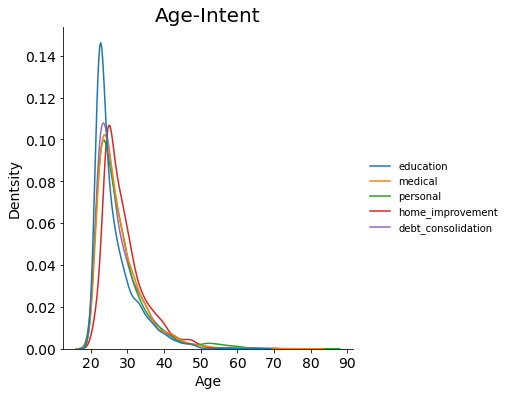

In [ ]:
sns.displot(
    {
        "education": df[df.loan_intent == 'EDUCATION'].person_age,
        "medical": df[df.loan_intent == 'MEDICAL'].person_age,
        "personal": df[df.loan_intent == 'PERSONAL'].person_age,
        "home_improvement": df[df.loan_intent == 'HOMEIMPROVEMENT'].person_age,
        "debt_consolidation": df[df.loan_intent == 'DEBTCONSOLIDATION'].person_age,
    },
    kind="kde",
    common_norm=False
)

plt.title('Age-Intent', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Если рассматривать кредит на образование, то его выбирали люди в основном от 20 до 30 лет. Также можно сказать и про обустройство дома, возрастной диапазон по этому виду кредита: 25-35 лет. По остальным направлениям отсутствуют существенные смещения. Из графика можно прийти к выводу о том, что с возрастом люди реже берут кредиты.

*Основные итоги анализа диаграмм:*



*   Набор данных в основном состоит из людей, погасивших кредит (78% против 22%)
*   Наиболее часто люди брали кредит на образование, реже - на обустройство дома
*   "А", "В" - самые популярные рейтинги кредитов
*   Арендующие жильё чаще допускали дефолт, чем собственники жилья
*   Люди с "плохой" кредитной историей больше склонны к дефолту
*   Ставка процента по кредиту в заёмщиков с дефолтом была в среднем выше
*   В группе людей невыплативших кредит, доходы в среднем ниже, чем в группе людей погасивших кредит  







# **Моделирование**

---






Поскольку многие методы машинного обучения не работают с признаками типа "object" (например, logistic regression), создадим бинарные признаки с помощью one-hot кодирования

Вывод всех столбцов с признаком 'object'

In [ ]:
df.select_dtypes(include=['object']).columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [ ]:
#One-hot кодирование для категориальных признаков
df = pd.get_dummies(data=df,columns=['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file'])

In [ ]:
df.head(5)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,0,0,1,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,0,0,0,...,0,0,0,1,0,0,0,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,0,0,1,...,1,1,0,0,0,0,0,0,1,0


Разделим набор данных на обучающую и тестовую выборки:

In [ ]:
y = df['loan_status']
X = df.drop('loan_status',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)



# **Logistic Regression**




Чтобы обучить логистическую регрессию, предварительно отмасштабируем признаки

In [ ]:
scaler = StandardScaler()                # масштабирование данных
scaler.fit(X_train)

X_train = scaler.transform(X_train)         #масштабирование обучающей выборки и тестовой выборки
X_test = scaler.transform(X_test)

Базовая модель без включения баланса классов:

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred_proba = lr.predict_proba(X_test)[:, 1]
y_pred_lr = lr.predict(X_test)

Построим матрицу ошибок для визуализации результатов:

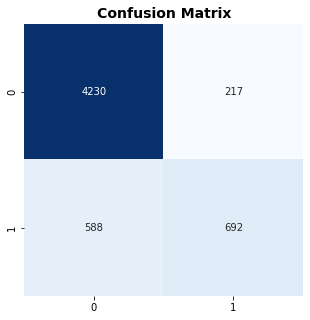

In [ ]:
plt.figure(figsize=(5,5))

sns.heatmap(confusion_matrix(y_test,y_pred_lr), annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title("Confusion Matrix", fontsize=14, fontweight='bold')

plt.show()

Точность показывает долю верно предсказанных положительных объектов среди всех предсказаний положительного класса:

$$
\text{precision}(a, X) = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

Полнота показывает долю верно предсказанных положительных объектов среди всех положительных объектов в данных:

$$
\text{recall}(a, X) = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

F-мера - это метрика, находящая некоторый баланс между точностью и полнотой. Ее значение - это их гармоническое среднее:

$$
\text{F-score}(a, X) = 2\frac{\text{precision}(a, X)\cdot\text{recall}(a, X)}{\text{precision}(a, X) + \text{recall}(a, X)}
$$

In [ ]:
df_report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])

df_report['ROC-AUC'] = roc_auc_score(y_test, y_pred_proba)
df_report['F1'] = f1_score(y_test, y_pred_lr)
df_report['precision_0'] = precision_score(y_test, y_pred_lr, pos_label=0)
df_report['recall_0'] = recall_score(y_test, y_pred_lr, pos_label=0)
df_report['precision_1'] = precision_score(y_test, y_pred_lr, pos_label=1)
df_report['recall_1'] = recall_score(y_test, y_pred_lr, pos_label=1)

df_report.index = ['LogisticRegression']
df_report

,ROC-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.869921,0.632252,0.877958,0.951203,0.761276,0.540625


Результаты ROC-AUC искажаются при несбалансированных классах, поскольку она будет показывать отличный результат (из-за того, что класса 0 явно больше, чем класс 1)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.



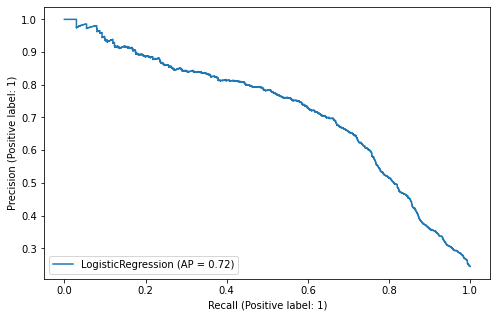

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 5))

plot_precision_recall_curve(lr, X_test, y_test, ax=ax1);

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



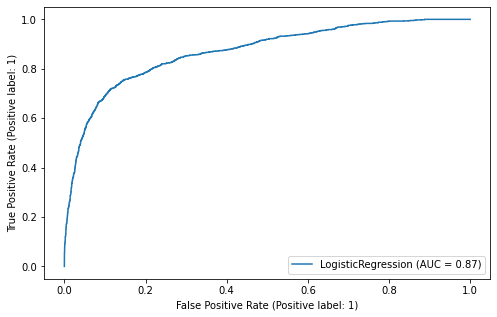

In [ ]:
fig, ax2 = plt.subplots(figsize=(8, 5));
plot_roc_curve(lr, X_test, y_test, ax=ax2);

Кажется, что модель показывает отличный результат, ROC-AUC = 0.87, но на самом деле, из-за дисбаланса, у наименьшего класса (класс 1) плохая полнота

Далее, применяя в моделях метод class_weight='balanced', будем подбирать наилучшие параметры и проводить стратификацию

Параметр "balanced"  применяется при дисбалансе классов:

In [ ]:
lr_strat = LogisticRegression(class_weight='balanced')
lr_strat.fit(X_train, y_train)
strat = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'C': np.linspace(0.001, 10, 10), 'penalty': ['l1', 'l2']}


clf_lr = GridSearchCV(
    lr_strat, param, scoring='roc_auc', refit=True, cv=strat)
clf_lr.fit(X_train, y_train)
clf_lr.best_score_, clf_lr.best_params_

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver

(0.8747431951807011, {'C': 1.1119999999999999, 'penalty': 'l2'})

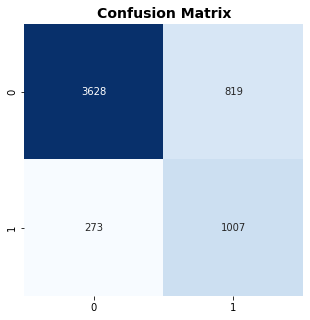

In [ ]:
y_pred_proba1 = lr_strat.predict_proba(X_test)[:, 1]
y_pred_lr1 = lr_strat.predict(X_test)
plt.figure(figsize=(5,5))

sns.heatmap(confusion_matrix(y_test,y_pred_lr1), annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title("Confusion Matrix", fontsize=14, fontweight='bold')

plt.show()

0,78 - доля дефолтов, которую модель смогла выявить. Итог: базовая модель не различает балансы классов, доля выявленных дефолтов 0,54 (на 24% меньше)

In [ ]:
def get_scores(report_df, model, X_test, y_test, name):

    report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
    report['ROC-AUC'] = roc_auc_score(y_test,
                                      model.predict_proba(X_test)[:, 1])
    report['F1'] = f1_score(y_test, model.predict(X_test))
    report['precision_0'] = precision_score(
        y_test, model.predict(X_test), pos_label=0)
    report['precision_1'] = precision_score(
        y_test, model.predict(X_test), pos_label=1)
    report['recall_0'] = recall_score(
        y_test, model.predict(X_test), pos_label=0)
    report['recall_1'] = recall_score(
        y_test, model.predict(X_test), pos_label=1)

    report.index = [name]
    report_df = report_df.append(report)
    return report_df
df_report = get_scores(df_report, lr_strat, X_test,
                       y_test, 'LogisticRegression_strat')

In [ ]:
df_report

,ROC-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.869921,0.632252,0.877958,0.951203,0.761276,0.540625
LogisticRegression_strat,0.871141,0.648422,0.930018,0.815831,0.551479,0.786719


Полнота меньшего класса (1) увеличилась на 24%, модель стала учитывать дисбаланс, при этом точность сократилась на 21%, f1 немного выросла из-за увеличения полноты

# **Random Forest**

Обучим модель, не учитывающую дисбаланс классов:

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

df_report = get_scores(df_report, rf, X_test, y_test, 'RandomForestClassifier')
df_report

,ROC-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.869921,0.632252,0.877958,0.951203,0.761276,0.540625
LogisticRegression_strat,0.871141,0.648422,0.930018,0.815831,0.551479,0.786719
RandomForestClassifier,0.931708,0.826535,0.925042,0.993479,0.969506,0.720313


Базовый Random Forest отработал лучше, чем линейная модель без каких-либо балансировок. f1 заметно увеличилась с 65% до 83%

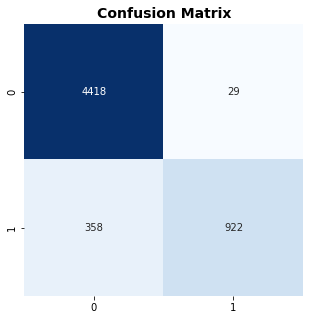

In [ ]:
y_pred_proba2 = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)

plt.figure(figsize=(5,5))

sns.heatmap(confusion_matrix(y_test,y_pred_rf), annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title("Confusion Matrix", fontsize=14, fontweight='bold')

plt.show()

Немного сократилась полнота, но увеличилась точность, т.е. доля верно распознанных дефолтов

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.



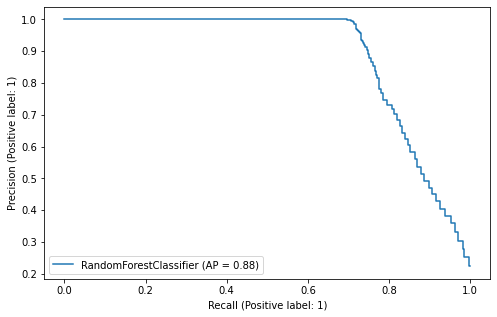

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 5));

plot_precision_recall_curve(rf, X_test,y_test, ax=ax1);

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



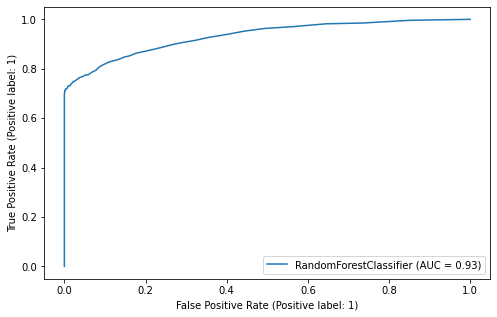

In [ ]:
fig, ax2 = plt.subplots(figsize=(8, 5));
plot_roc_curve(rf, X_test,y_test, ax=ax2);

Применение параметра 'balanced'

In [ ]:
rf_strat = RandomForestClassifier(class_weight='balanced')

skf = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'bootstrap': [True],
         'max_depth': [10, 30],
         'n_estimators': [600, 1000]}

clf_rf = GridSearchCV(
    rf_strat, param, scoring='roc_auc', refit=True, cv=strat, verbose=3, n_jobs=-1)
clf_rf.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=10, test_size=None,
            train_size=None),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 30],
                         'n_estimators': [600, 1000]},
             scoring='roc_auc', verbose=3)

Fitting 5 folds for each of 4 candidates, totalling 20 fits



GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=10, test_size=None,
            train_size=None),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 30],
                         'n_estimators': [600, 1000]},
             scoring='roc_auc', verbose=3)

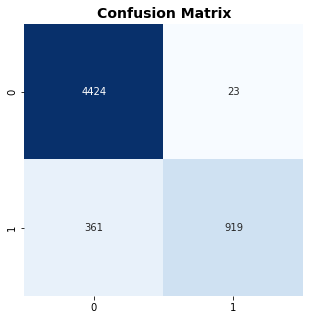

In [ ]:
rf_strat.fit(X_train, y_train)
y_pred_proba3 = rf_strat.predict_proba(X_test)[:, 1]
y_pred_rf1 = rf_strat.predict(X_test)
plt.figure(figsize=(5,5))

sns.heatmap(confusion_matrix(y_test,y_pred_rf1), annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title("Confusion Matrix", fontsize=14, fontweight='bold')

plt.show()

In [ ]:
df_report = get_scores(df_report, clf_rf, X_test, y_test, 'RandomForestClassifier_strat')
df_report

,ROC-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.869921,0.632252,0.877958,0.951203,0.761276,0.540625
LogisticRegression_strat,0.871141,0.648422,0.930018,0.815831,0.551479,0.786719
RandomForestClassifier,0.931708,0.826535,0.925042,0.993479,0.969506,0.720313
RandomForestClassifier_strat,0.934722,0.825696,0.924493,0.993928,0.971459,0.717969


Модель практически идентична базовой модели Random Forest. Это связано с тем, что Случайные леса относительно устойчивы к отсутствующим и несбалансированным данным

# **Lightgbm**

Базовая модель:

In [ ]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train, categorical_feature='auto')

df_report = get_scores(df_report, lgb, X_test,
                       y_test, 'LGBMClassifier')
df_report

,ROC-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.869921,0.632252,0.877958,0.951203,0.761276,0.540625
LogisticRegression_strat,0.871141,0.648422,0.930018,0.815831,0.551479,0.786719
RandomForestClassifier,0.931708,0.826535,0.925042,0.993479,0.969506,0.720313
RandomForestClassifier_strat,0.934722,0.825696,0.924493,0.993928,0.971459,0.717969
LGBMClassifier,0.945493,0.832583,0.925810,0.996177,0.981953,0.722656


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.



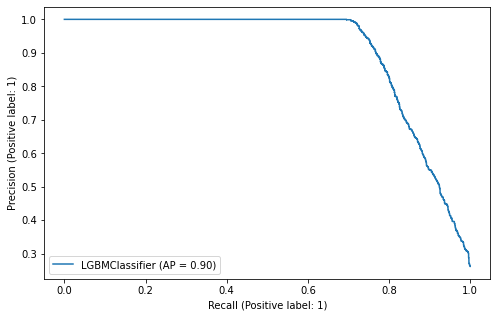

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 5));

plot_precision_recall_curve(lgb, X_test, y_test, ax=ax1);


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



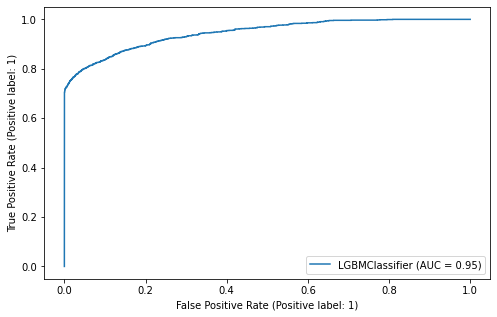

In [ ]:
fig, ax2 = plt.subplots(figsize=(8, 5));

plot_roc_curve(lgb, X_test, y_test, ax=ax2);

Найдем наилучшие параметры модели с class_weight='balanced'

In [ ]:
lgb_strat = LGBMClassifier(class_weight='balanced')


param = {'learning_rate': [0.005, 0.1],
         'num_leaves': [30, 50],
         'n_estimators': [500, 600]}

clf_lgb = GridSearchCV(lgb_strat, param, scoring='roc_auc',
                       cv=skf, verbose=3, n_jobs=-1)
clf_lgb.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=10, test_size=None,
            train_size=None),
             estimator=LGBMClassifier(class_weight='balanced'), n_jobs=-1,
             param_grid={'learning_rate': [0.005, 0.1],
                         'n_estimators': [500, 600], 'num_leaves': [30, 50]},
             scoring='roc_auc', verbose=3)

In [ ]:
df_report = get_scores(df_report, clf_lgb, X_test, y_test,
                       'LGBMClassifier_skf')
df_report

,ROC-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.869921,0.632252,0.877958,0.951203,0.761276,0.540625
LogisticRegression_strat,0.871141,0.648422,0.930018,0.815831,0.551479,0.786719
RandomForestClassifier,0.931708,0.826535,0.925042,0.993479,0.969506,0.720313
RandomForestClassifier_strat,0.934722,0.825696,0.924493,0.993928,0.971459,0.717969
LGBMClassifier,0.945493,0.832583,0.925810,0.996177,0.981953,0.722656
LGBMClassifier_skf,0.944831,0.827160,0.939917,0.967394,0.873913,0.785156


Лучшей оказалась модель Lightgbm скорректированная на дисбаланс классов в целевой переменной. 0,78-доля дефолтов, которую модель смогла выявить. 0,87 - доля верно распознанных дефолтов, 0,82 -среднее гармоническое, параметр, учитывающих точность и полноту. Если сравнивать с логистической регрессией, то recall для 1 класса практически идентичны, но у lightgb выше баланс между точностью и полнотой (f1)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.



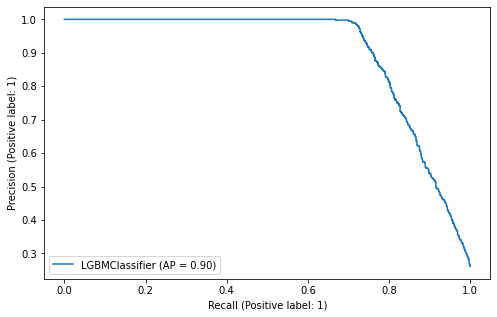

In [ ]:
lgb_strat.fit(X_train, y_train)
fig, ax1 = plt.subplots(figsize=(8, 5));

plot_precision_recall_curve(lgb_strat, X_test, y_test, ax=ax1);

Рассмотрим важность признаков для модели lgb_strat:

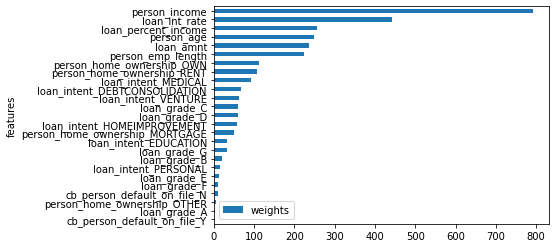

In [ ]:

sorted_weights=sorted(zip(lgb_strat.feature_importances_.ravel(),X.columns),reverse=False)
weights=[x[0] for x in sorted_weights]
features=[x[1] for x in sorted_weights]
df_df=pd.DataFrame({'features': features, 'weights':weights})
ahg=df_df.plot.barh(x='features',y='weights',rot=0)

ТОП-3 наиболее важные признаки для модели: доход человека, ставка процента по кредиту, процент от дохода на кредит. Что подтверждает гипотезы, выдвинутые в начале проекта. Средний доход людей без дефолтов выше, что свидетельствует о правиле: выше доход - выше платежеспособность. Ставка процента у людей с дефолтом в среднем была выше, что тоже влияет на способность человека погасить кредит, и процент, отчисляемый от дохода, ранее мы выяснили, он редко превышает 30%